In [1]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [6]:
WEB_PAGE_DATA_CSV = './data/web_page_data.csv'

session_times = pd.read_csv(WEB_PAGE_DATA_CSV)

In [8]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

/Users/v0m01sk/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


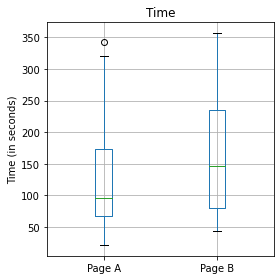

In [10]:
ax = session_times.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [11]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
mean_b - mean_a

35.66666666666667

### permutation test

In [13]:
# Permutation test example with stickiness
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()
    
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

-22.61904761904762


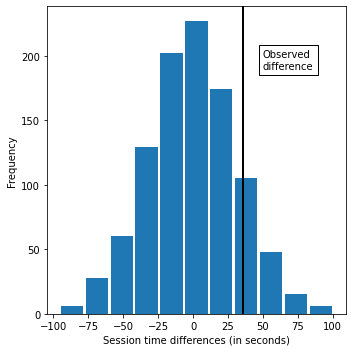

In [14]:
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [15]:
print(np.mean(perm_diffs > mean_b - mean_a))

0.121


### statistical significance and p values

Observed difference: 0.0368%


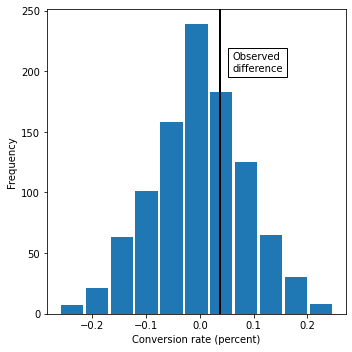

In [17]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) 
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [18]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


In [19]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


# t-Tests

In [20]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


## ANOVA

In [24]:
FOUR_SESSIONS_CSV = './data/four_sessions.csv'

four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

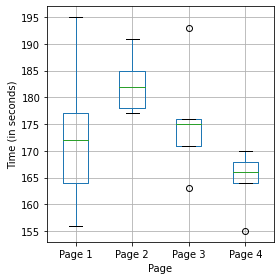

In [25]:
ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [26]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)
# Permutation test example with stickiness
def perm_test(df): 
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
21.906666666666656


Pr(Prob) 0.08333333333333333


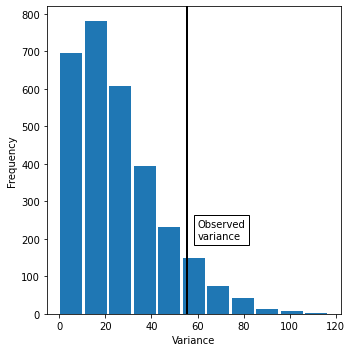

In [27]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## F-Statistic
We can compute an ANOVA table using statsmodel.

In [28]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
                
aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


In [29]:
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

F-Statistic: 1.3699
p-value: 0.0388


### chi square test

In [32]:
CLICK_RATE_CSV = './data/click_rates.csv'
click_rate = pd.read_csv(CLICK_RATE_CSV)

In [33]:
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


In [34]:
# Table 3-5
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [35]:
# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4820


In [36]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


In [37]:
IMANISHI_CSV = './data/imanishi_data.csv'

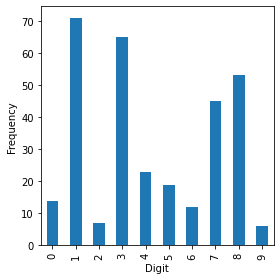

In [38]:
imanishi = pd.read_csv(IMANISHI_CSV)
imanishi.columns = [c.strip() for c in imanishi.columns]
ax = imanishi.plot.bar(x='Digit', y=['Frequency'], legend=False,
                      figsize=(4, 4))
ax.set_xlabel('Digit')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Power and Sample Size
statsmodels has a number of methods for power calculation

see e.g.: https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/

## 10% improvement

In [42]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.393


## 50% improvement

In [44]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408
